In [1]:
import requests
import apimoex
import ts2vg as ts
from igraph import *
import numpy as np
import networkx as nx
import igraph as ig
import cairocffi
import matplotlib.pyplot as plt
import pandas as pd

In [186]:
import random
random.seed(0)

#### TASK 1

<Axes: >

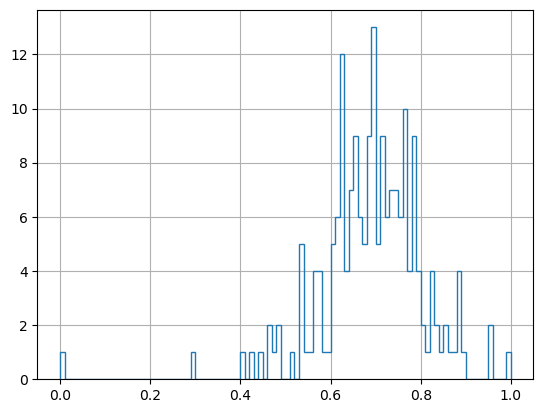

In [181]:
# download MOEX data , calculate normilized returns
# display it into visibility graph: regular and horizontal
# plot and compare

with requests.Session() as session:
    data = apimoex.get_board_history(session, 'GAZP')
    df = pd.DataFrame(data).drop(columns=['VALUE', 'BOARDID'])
    df.set_index('TRADEDATE', inplace=True)
    df.index = pd.to_datetime(df.index)
    df = df[pd.to_datetime('2023-01-01'):]
    
df['log_return'] = df['CLOSE'].pct_change()
df = df.dropna()
df['norm_return'] = (df['log_return'].max() - df['log_return']) / (df['log_return'].max() - df['log_return'].min())
df['norm_return'].hist(histtype='step', bins=100)

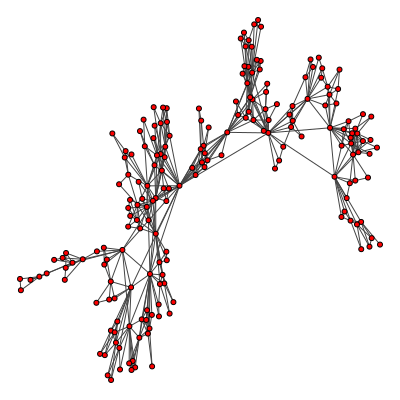

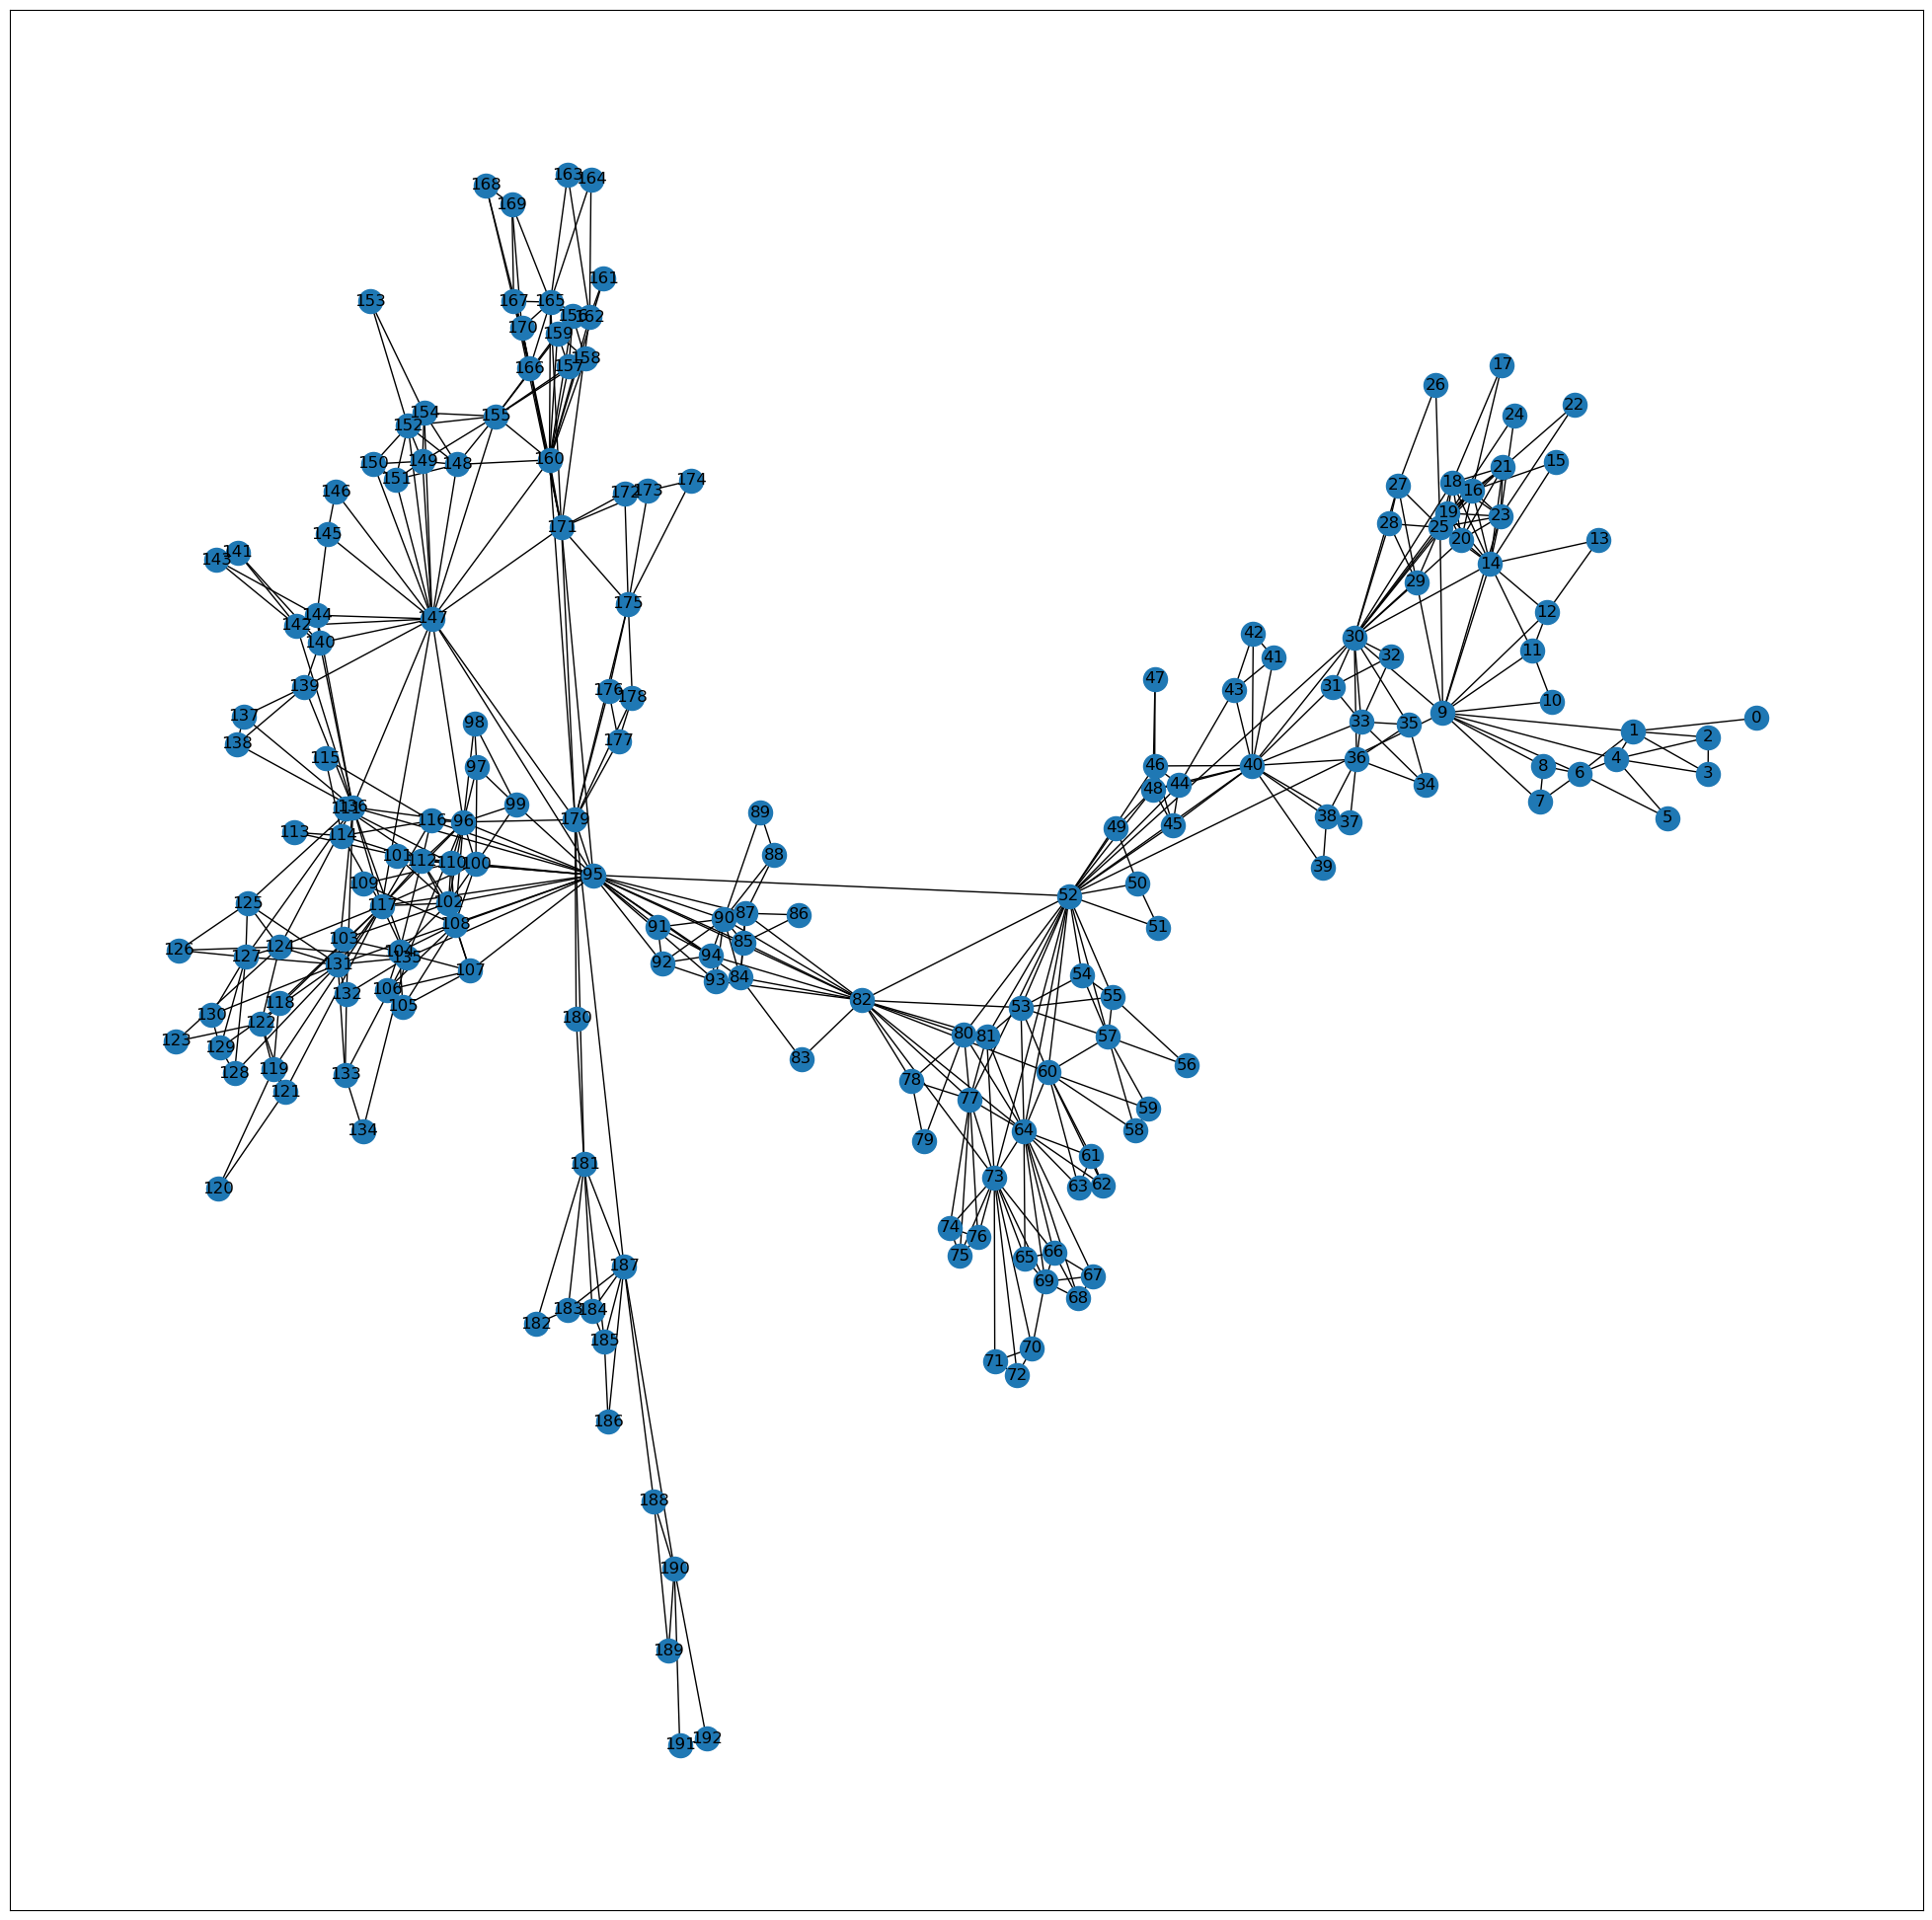

<Figure size 200x200 with 0 Axes>

In [188]:
vg = ts.NaturalVG()
vg.build(df['norm_return'])

ivg = vg.as_igraph()
nxvg = vg.as_networkx()

plt.figure(figsize =(25, 25))
nx.draw_networkx(nxvg, with_labels = True)

# plot the graph
plt.figure(figsize=(2, 2))
ig.plot(ivg,
        vertex_size=5,
        #vertex_label=g.vs['names'],
        #edge_label=g.es['weight'],
        bbox=(400, 400),
        rand
        )

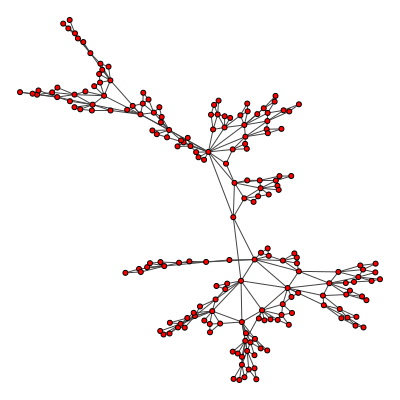

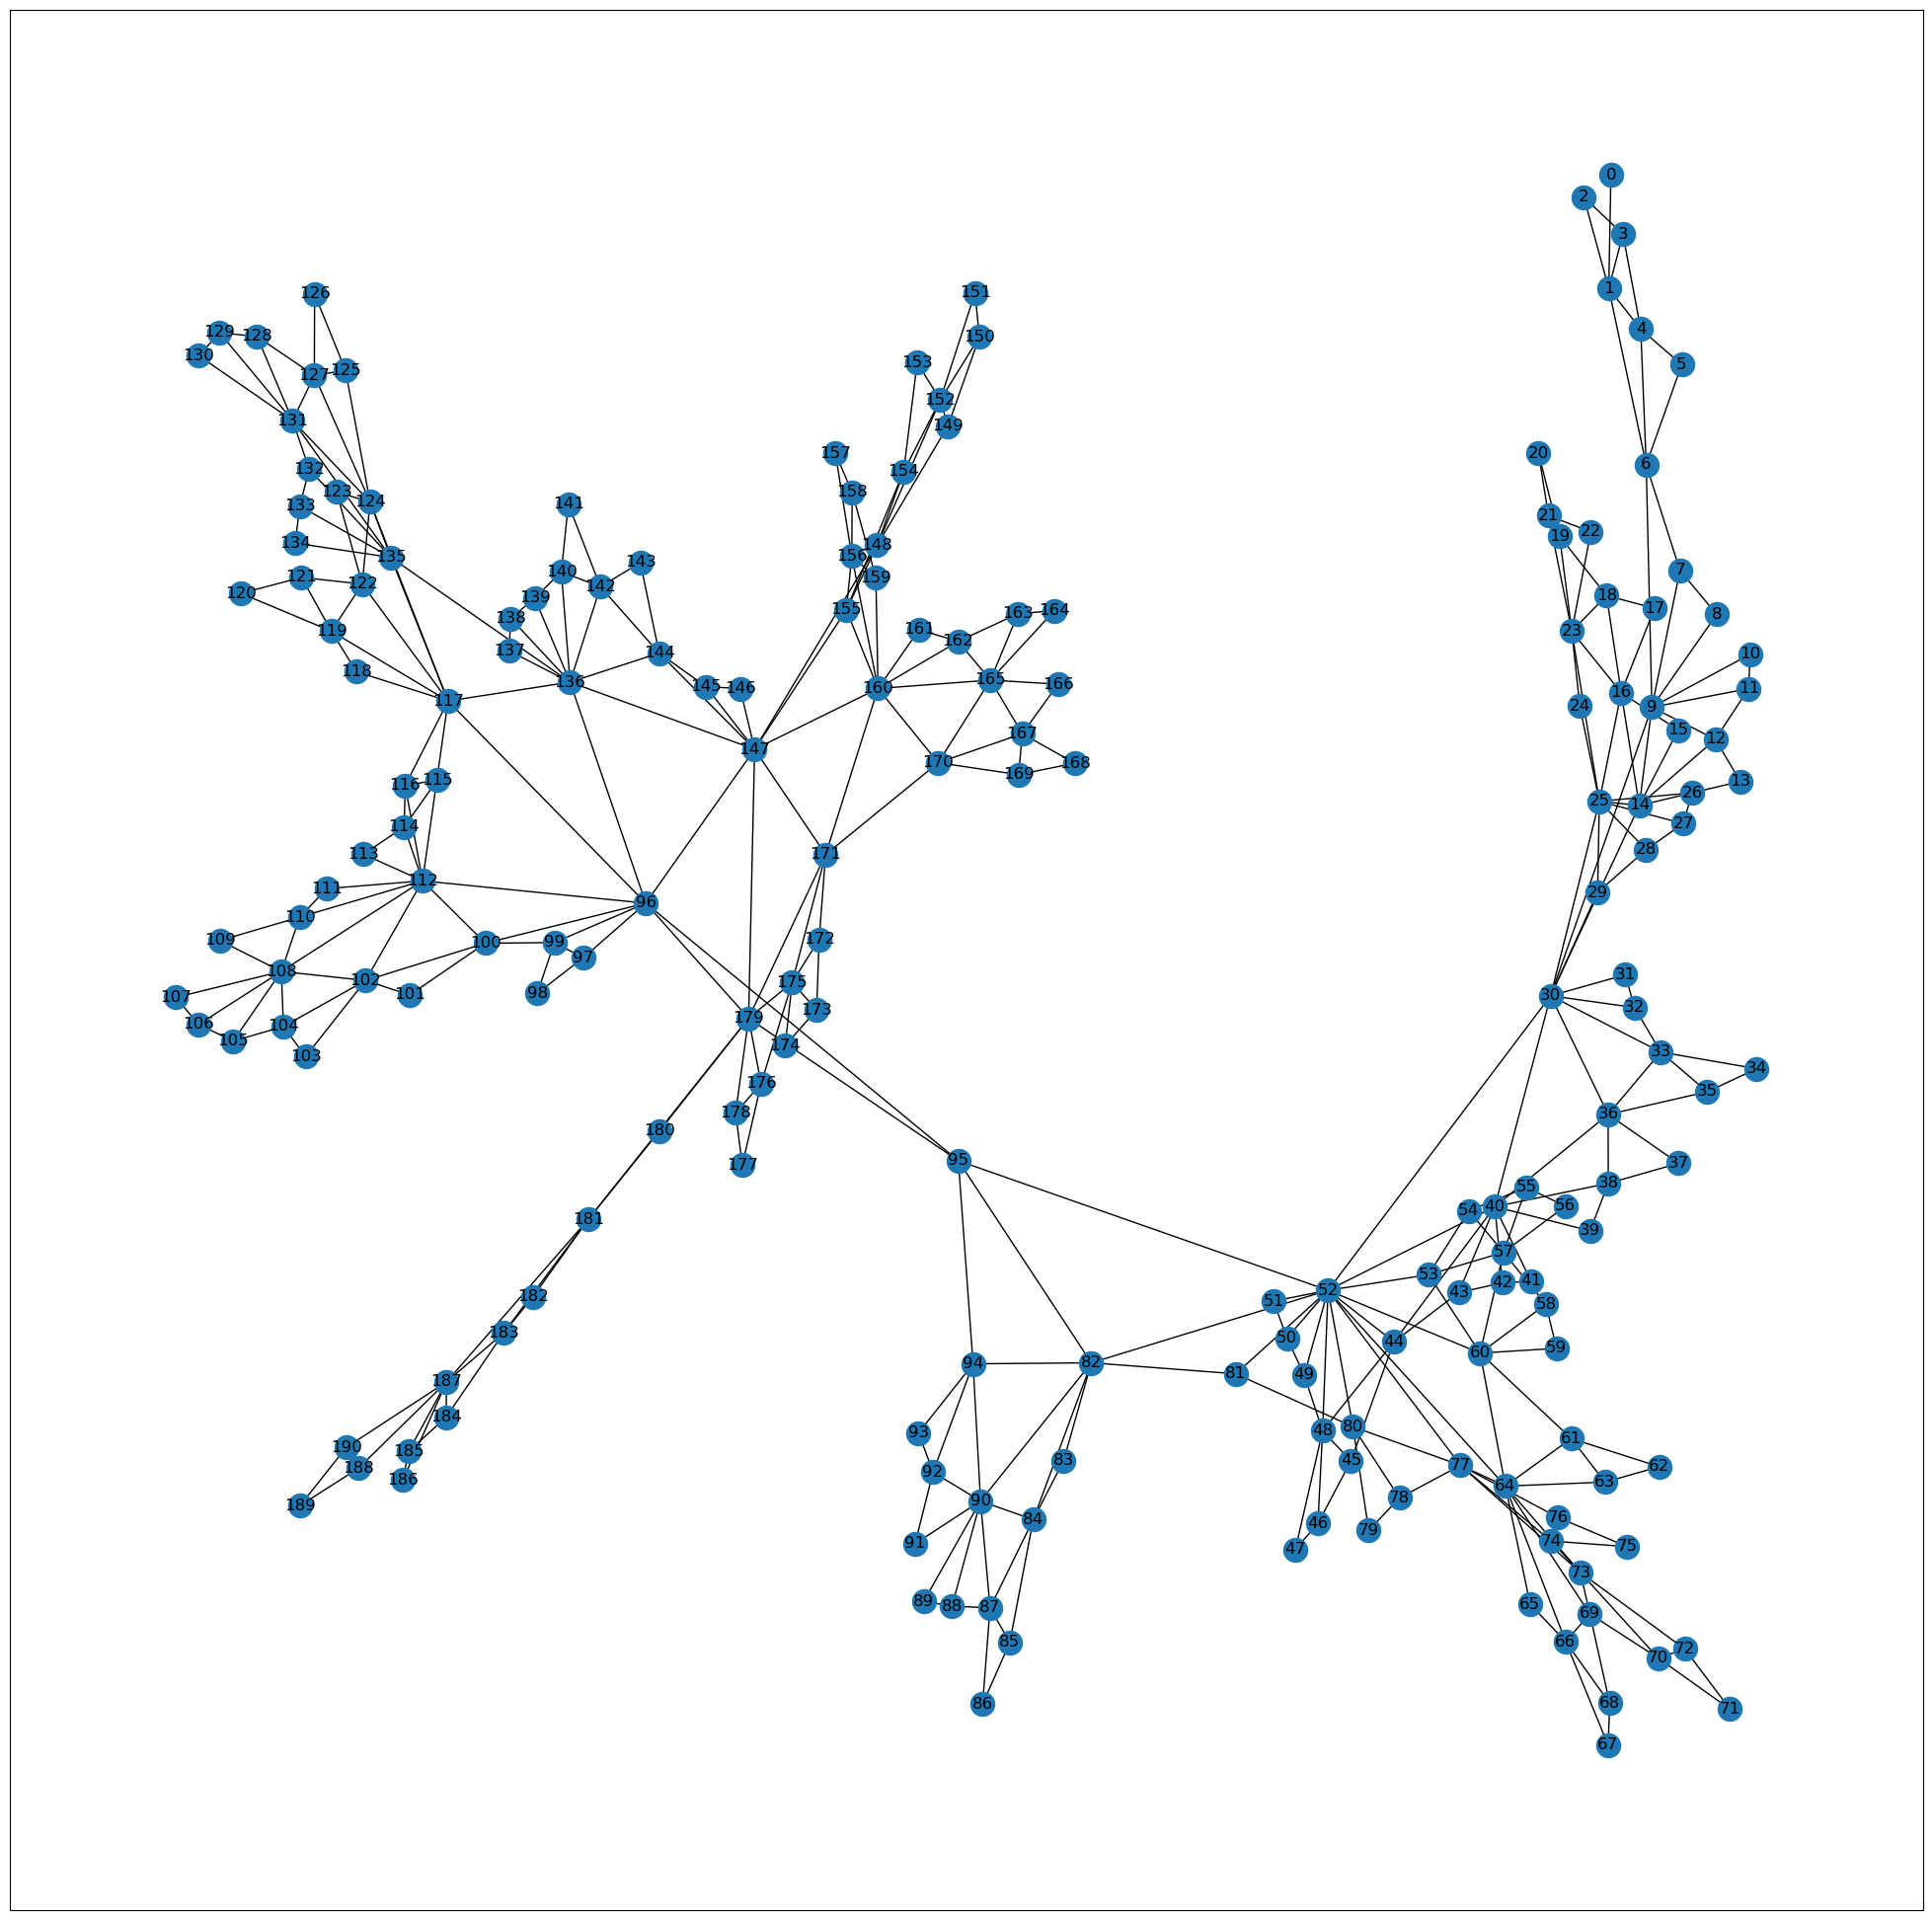

<Figure size 200x200 with 0 Axes>

In [4]:
vg = ts.HorizontalVG()
vg.build(df['norm_return'])

ihg = vg.as_igraph()
nxhg = vg.as_networkx()

plt.figure(figsize =(25, 25))
nx.draw_networkx(nxhg, with_labels = True)

# plot the graph
plt.figure(figsize=(2, 2))
ig.plot(ihg,
        vertex_size=5,
        #vertex_label=g.vs['names'],
        #edge_label=g.es['weight'],
        bbox=(400, 400)
        )

In [208]:
from scipy import sparse

In [320]:
# compare two ways constructed graphs
print(f'Compare according adjacency matrices : {list(nxhg.adjacency()) == list(nxvg.adjacency())}')
print(f'Compare according adjacency matrices : { np.isclose(np.array(list(ihg.get_adjacency())), np.array(sparse.lil_matrix(nx.adjacency_matrix(nxhg)).toarray())).all()}')

Compare according adjacency matrices : False
Compare according adjacency matrices : True


#### TASK 2

In [51]:
tickers = ['GAZP', 'SBER', 'LKOH']#, 'YNDX', 'GMKN', 'NVTK', 'ROSN']
data_dict = {}
with requests.Session() as session:
    for ticker in tickers:
        data_dict[ticker] = pd.DataFrame(apimoex.get_board_history(session, ticker)).set_index('TRADEDATE')
        data_dict[ticker].index = pd.to_datetime(data_dict[ticker].index)
        data_dict[ticker] = data_dict[ticker]['CLOSE']

In [52]:
start_date = pd.to_datetime('2023-01-01')

tickers_df = pd.DataFrame(data_dict).dropna()[start_date:]

for ticker in tickers:
    tickers_df[f'{ticker}_norm_return'] = tickers_df[ticker].pct_change()
    tickers_df = tickers_df.dropna()
    tickers_df[f'{ticker}_norm_return'] = (tickers_df[f'{ticker}_norm_return'].max() - tickers_df[f'{ticker}_norm_return']) / (tickers_df[f'{ticker}_norm_return'].max() - tickers_df[f'{ticker}_norm_return'].min())
    tickers_df[f'{ticker}_norm_return'] = 2 * tickers_df[f'{ticker}_norm_return'] - 1

In [136]:
for ticker in tickers:
    tickers_df[f'mc_{ticker}'] = 'e'
    mask_R = tickers_df[f'{ticker}_norm_return'] > 0.3
    mask_r = tickers_df[f'{ticker}_norm_return'] > 0.05
    mask_d = tickers_df[f'{ticker}_norm_return'] < -0.05
    mask_D = tickers_df[f'{ticker}_norm_return'] < -0.3
    
    tickers_df.loc[(tickers_df[mask_r]).index, f'mc_{ticker}'] = 'r'
    tickers_df.loc[(tickers_df[mask_R]).index, f'mc_{ticker}'] = 'R'
    tickers_df.loc[(tickers_df[mask_D]).index, f'mc_{ticker}'] = 'D'
    tickers_df.loc[(tickers_df[mask_d]).index, f'mc_{ticker}'] = 'd'

In [160]:
mc_tickers = [f'mc_{ticker}' for ticker in tickers]
for date in tickers_df.index:
    tickers_df['market_condition'] = ''
    for ticker in mc_tickers:
        tickers_df['market_condition'] += tickers_df[ticker]

In [161]:
tickers_df['mc_transition'] = tickers_df['market_condition'] + tickers_df.shift(-1)['market_condition']
tickers_df = tickers_df.dropna()

In [303]:
transitions_dict = {}
for condition in tickers_df.market_condition.unique():
    transitions_dict[condition] = {}
    condition_state_num = tickers_df[tickers_df['market_condition'] == condition].count()[0]
    for condition2 in tickers_df.market_condition.unique():
        cond2cond_num = tickers_df[tickers_df['mc_transition'] == (condition + condition2)].count()[0]
        transitions_dict[condition][condition2] = round(cond2cond_num / condition_state_num, 3)

In [309]:
transitions_dict_df = pd.DataFrame(transitions_dict)
#transitions_dict_df = transitions_dict_df[transitions_dict_df != 0 ]

In [310]:
adjacency_matrix = np.zeros(shape=(len(transitions_dict), len(transitions_dict)), dtype=float)

for i, (condition1, transitions) in enumerate(transitions_dict.items()):
    for j, (condition2, transition_prob) in enumerate(transitions.items()):
        #print(condition1, i, condition2, j, transition_prob)
        adjacency_matrix[i, j] = transition_prob
        
#g = ig.Graph.Adjacency((adjacency_matrix > 0).tolist())
g = ig.Graph.Adjacency((adjacency_matrix > 0).tolist())
g.vs['names'] = [key for key in transitions_dict.keys()]
g.es['weight'] = adjacency_matrix[adjacency_matrix.nonzero()]

G = nx.DiGraph(transitions_dict_df > 0)

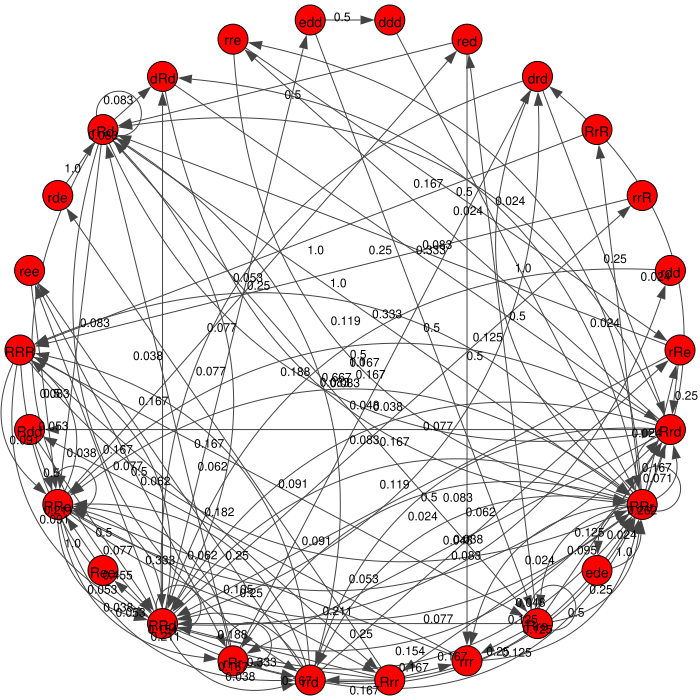

<Figure size 1000x1000 with 0 Axes>

In [322]:
# plot the graph
plt.figure(figsize=(10, 10))
ig.plot(g,
        vertex_size=30,
        vertex_label=g.vs['names'],
        edge_label=g.es['weight'],
        bbox=(700, 700),
        layout='circular',
        )

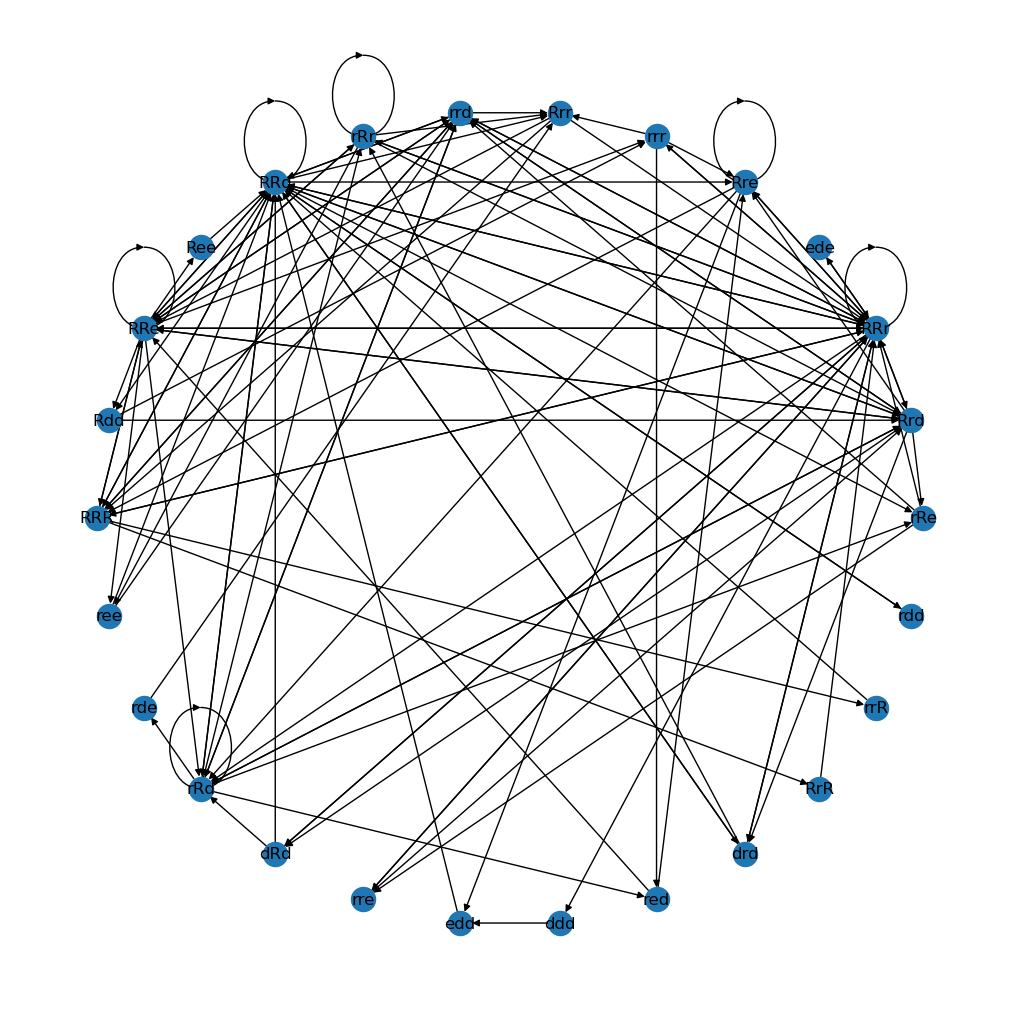

In [321]:
plt.figure(figsize =(10, 10))
nx.draw_circular(G, with_labels = True, )

#### TASK 3